# Density PDF emulator

In [20]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from sunbird.emulators import FCN, train
from sunbird.data import ArrayDataModule

plt.style.use(os.path.join(os.path.abspath('../'), 'plot_style.mplstyle'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
data_dir = Path('/pscratch/sd/m/mpinon/density/training_sets/hod/c000_ph000/seed0/')
data_fn = Path(data_dir) / 'cgf_r10_lhc.npy'
lhc = np.load(data_fn, allow_pickle=True,).item()

In [36]:
lda = lhc['lambda']
lhc_x = lhc['lhc_x']
lhc_x_names = lhc['lhc_x_names']
lhc_y = lhc['lhc_y']

In [37]:
n = len(lhc_y)
test_frac = 0.1
n_val = int(np.round(test_frac * n))

In [38]:
# mask out high lambda values
mask = lda < 7
lhc_y = lhc_y[:, mask]
lda = lda[mask]

In [25]:
lhc_train_x = lhc_x[:-n_val]
lhc_train_y = lhc_y[:-n_val]
lhc_test_x = lhc_x[-n_val:]
lhc_test_y = lhc_y[-n_val:]   

## Load model and test it

In [26]:
# To load a model from a saved checkpoint:
checkpoint_fn = "/global/homes/m/mpinon/density/emulator/cgf/hod/last.ckpt"
model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
model = model.to('cpu')

In [27]:
# and now let's test it
model.eval()
with torch.no_grad():
    pred_test_y  = model.get_prediction(torch.Tensor(lhc_test_x))
pred_test_y = pred_test_y.numpy()
pred_test_y = pred_test_y

ValueError: x and y must have same first dimension, but have shapes (49,) and (570,)

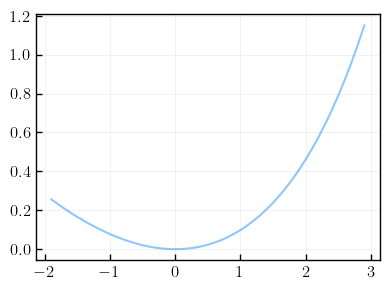

In [28]:
plt.figure(figsize=(4, 3))
# let's plot some predictions vs truth
for i in range(5):
    plt.plot(lda, lhc_test_y.T[:, i], color='C{}'.format(i), alpha=0.5, label='mock' if i==0 else '')
    plt.plot(lda, pred_test_y.T[:, i], color='C{}'.format(i), ls='--', label='prediction' if i==0 else '')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\phi(\lambda)$')
plt.legend()
plt.show()

In [39]:
# Compare to cosmic variance

# rescale cov to the volume of the diffsky mocks
prefactor = 1 / 8

# Read small boxes measurements for covariance
data_dir = Path('/pscratch/sd/m/mpinon/density/cov/')
data_fn = Path(data_dir) / 'cgf_r10_cov_lhc.npy'
lhc_cov_pdf = np.load(data_fn, allow_pickle=True,).item()
cov_pdf = prefactor * np.cov(lhc_cov_pdf['lhc_y'][:, mask], rowvar=False)
#mean_pdf = np.mean(lhc_cov_pdf['lhc_y'], axis=0)
#std_pdf = np.diag(cov_pdf)**0.5

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


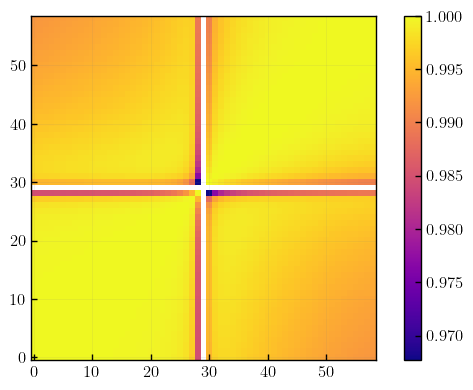

In [40]:
correlation_matrix = np.corrcoef(np.array(cov_pdf).T)

plt.imshow(correlation_matrix, origin='lower')
#plt.xlabel(r'$\delta_R$')
#plt.ylabel(r'$\delta_R$')
plt.colorbar()
plt.show()

In [41]:
cov_pdf.shape

(59, 59)

In [42]:
np.linalg.matrix_rank(cov_pdf)

18

/tmp/ipykernel_2220880/870243812.py:6: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(lda, (lhc_test_y.T[:, i]-pred_test_y.T[:, i])/std_pdf, color='C{}'.format(i), ls='--', label='prediction' if i==0 else '')


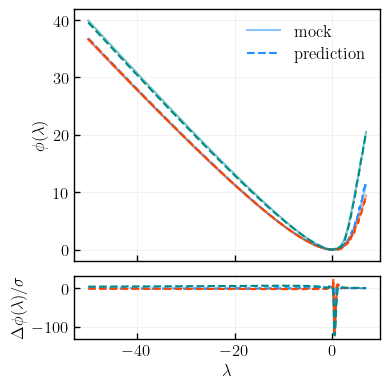

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True, height_ratios=(4, 1))
# let's plot some predictions vs truth
for i in range(3):
    ax[0].plot(lda, lhc_test_y.T[:, i], color='C{}'.format(i), alpha=0.5, label='mock' if i==0 else '')
    ax[0].plot(lda, pred_test_y.T[:, i], color='C{}'.format(i), ls='--', label='prediction' if i==0 else '')
    ax[1].plot(lda, (lhc_test_y.T[:, i]-pred_test_y.T[:, i])/std_pdf, color='C{}'.format(i), ls='--', label='prediction' if i==0 else '')
plt.xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\phi(\lambda)$')
ax[1].set_ylabel(r'$\Delta \phi(\lambda) / \sigma$')
#ax[0].set_xlim(-1, 3)
ax[0].legend()
plt.show()

/tmp/ipykernel_2220880/556328429.py:1: RuntimeWarning: invalid value encountered in divide
  emulator_error = (pred_test_y - lhc_test_y)/std_pdf


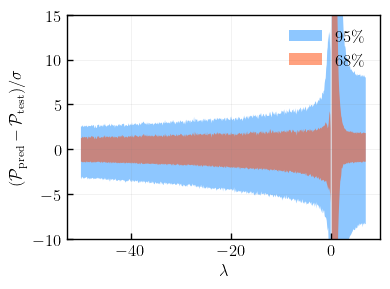

In [ ]:
emulator_error = (pred_test_y - lhc_test_y)/std_pdf

q68 = np.quantile(emulator_error, [0.16, 0.84], axis=0)
q95 = np.quantile(emulator_error, [0.025, 0.975], axis=0)
q99 = np.quantile(emulator_error, [0.005, 0.995], axis=0)

plt.figure(figsize=(4, 3))
plt.fill_between(lda, q95[0], q95[1], alpha=0.5, label='95\%',)
plt.fill_between(lda, q68[0], q68[1], alpha=0.5, label='68\%',) 
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$(\mathcal{P}_{\mathrm{pred}} - \mathcal{P}_{\mathrm{test}})/\sigma$')
plt.ylim(-10, 15)
plt.show()